In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
import qutip as qt


# Project-specific imports
import c2qa
import c2qa.util as util



This notebook looks at implementing the 1D Holstein model using hybrid qubit-qumode architechture. 
The one-dimensional version of the Holstein model reads

$$
\hat{H} = - \sum_{\langle i, j \rangle} V f^\dagger_i f_j + \sum_i \omega b^\dagger_i b_i + \sum_i g \omega f^\dagger_i f_i (b^\dagger_i + b_i),
$$

with $V$ the hopping coefficient between the nearest neighbour pair $\langle i, j \rangle$, $\omega$ the vibration frequency, and $g$ the coupling constant. For simplicity, we will first choose a two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$
We first note that in this architechture, for e.g. the first term, we will need oscillator-mediated multi-qubit gates, however, for now, we ignore this requirement.

Using a Jordan-Wigner mapping, the first term $ -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) = -V/2(X_1X_2 = Y_1Y_2)$ corresponds to an fSim gate. We define this first below.



In [ ]:
def hopping_term(theta):
    """
    Create an fSim gate defined as U(t)=exp(i Vt/2 (XX+YY)).
    """
    
    U = np.array([
        [1,               0,               0, 0],
        [0,  np.cos(theta), 1j * np.sin(theta), 0],
        [0, 1j * np.sin(theta),  np.cos(theta), 0],
        [0,               0,               0, 1]
    ])
    return UnitaryGate(U, label="fSim")


The $\omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr)$ term can be implemented at each site individually using a phase space rotation gate $\text{exp}(-i\theta n_i)$, with $\theta = \omega$. Finally, the boson-fermion coupling term $f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) = (Z_1 + 1)(b_1^{\dagger} + b_1)$, which is easy to implement as all terms in the sum commute and each
has a simple implementation; the term proportional to $Z_1$ generates a conditional displacement gate and the remaining term is a dispacement.

quick note about displacements: bosonic qiskit defines $D(\alpha) = \text{exp}(\alpha a^\dagger- \alpha^* a)$. So, to implement $ \text{exp}(-i\phi(a^\dagger + a))$, we need to choose $D(-i\phi)$. The same is true for conditional displacements.

In [ ]:
def simulate_holstein_model(dt, num_trotter, v, omega, g, num_qubits_per_qumode = 3):
    """
    Simulate the Holstein model for 2 sites using a Trotter decomposition.
    """

    num_sites = 2
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites, num_qubits_per_qumode=num_qubits_per_qumode)   # Create the bosonic and qubit registers
    qbr = qiskit.QuantumRegister(num_sites)
    circuit = c2qa.CVCircuit(qmr, qbr)

    circuit.initialize([0, 0, 1, 0], qbr) # Iniitalize fermion in mode ?

    for step in range(num_trotter):
        fsim_gate = hopping_term(v * dt) 
        circuit.append(fsim_gate, [qbr[0], qbr[1]]) # Hopping term between fermion

        # Bosonic rotation terms (each qumode rotates by omega*dt)
        circuit.cv_r(omega * dt, qmr[0])
        circuit.cv_r(omega * dt, qmr[1])

        # Coupling terms between bosonic modes and fermionic qubits.
        circuit.cv_c_d(-1j*(g * omega / 2) * dt, qmr[0], qbr[0])
        circuit.cv_d(-1j*(g * omega / 2) * dt, qmr[0])
        circuit.cv_c_d(-1j*(g * omega / 2) * dt, qmr[1], qbr[1])
        circuit.cv_d(-1j*(g * omega / 2) * dt, qmr[1])

    state, _, _ = c2qa.util.simulate(circuit)
    return state, circuit

def compute_populations(state, circuit, d):
    """
    Compute the electron (qubit) populations and the bosonic (qumode) populations on both sites.

    """
    # Partial trace to get the reduced density matrices:
    electron_dm = c2qa.util.trace_out_qumodes(circuit, state)
    boson_dm = c2qa.util.trace_out_qubits(circuit, state)
    
    # Convert to Qutip Qobjs with proper dimensions.
    electron_qobj = qt.Qobj(electron_dm, dims=[[2, 2], [2, 2]])
    
    # Define electron number operators.
    proj_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
    n0_e = qt.tensor(proj_1, qt.qeye(2)) # On site 0: tensor(|1><1|, identity)
    n1_e = qt.tensor(qt.qeye(2), proj_1) # On site 1: tensor(identity, |1><1|)
    
    pop_electron_site0 = qt.expect(n0_e, electron_qobj)
    pop_electron_site1 = qt.expect(n1_e, electron_qobj)
        
    # Set the proper dimensions for bosonic Qobj:
    boson_qobj = qt.Qobj(boson_dm, dims=[[d, d], [d, d]])
    
    a = qt.destroy(d)
    n_op = a.dag() * a  # number operator for one mode
    
    n1_b = qt.tensor(n_op, qt.qeye(d)) # On site 1: tensor(n_op, identity) #little endian
    n0_b = qt.tensor(qt.qeye(d), n_op) # On site 0: tensor(identity, n_op)
    
    pop_boson_site0 = qt.expect(n0_b, boson_qobj)
    pop_boson_site1 = qt.expect(n1_b, boson_qobj)
    
    return {
        "electron_populations": [pop_electron_site0, pop_electron_site1],
        "boson_populations": [pop_boson_site0, pop_boson_site1]
    }

In [ ]:
def exact_qutip_holstein_sim(v=1.0, omega=1.0, g=1.0, N_b=8, t_max=5, num_steps=100):
    """
    Performs an exact simulation of the two-site Holstein model using qutips qt.mesolve.
    """
    times_exact = np.linspace(0, t_max, num_steps)
    
    # Define Hilbert spaces and basis states
    e1 = qt.basis(2, 0)  # electron on site 1
    e2 = qt.basis(2, 1)  # electron on site 2
    
    # Electron projectors
    n1_proj = e1 * e1.dag()
    n2_proj = e2 * e2.dag()
    
    # Bosonic operators for a single mode 
    b1_exact = qt.destroy(N_b)
    b2_exact = qt.destroy(N_b)
    I_b_exact = qt.qeye(N_b)
    I_e_exact = qt.qeye(2)
    
    # Embed operators in the full Hilbert space: [electron, boson1, boson2]
    n1_tot_exact = qt.tensor(n1_proj, I_b_exact, I_b_exact)
    n2_tot_exact = qt.tensor(n2_proj, I_b_exact, I_b_exact)
    
    b1_tot_exact = qt.tensor(I_e_exact, b1_exact, I_b_exact)
    b1_dag_tot_exact = b1_tot_exact.dag()
    b2_tot_exact = qt.tensor(I_e_exact, I_b_exact, b2_exact)
    b2_dag_tot_exact = b2_tot_exact.dag()
    
    # Electron hopping operators
    f1_dag_f2 = e1 * e2.dag()
    f2_dag_f1 = e2 * e1.dag()
    f1_dag_f2_tot = qt.tensor(f1_dag_f2, I_b_exact, I_b_exact)
    f2_dag_f1_tot = qt.tensor(f2_dag_f1, I_b_exact, I_b_exact)
    
    # Construct the Hamiltonian
    # Hopping term
    H_hop_exact = -v * (f1_dag_f2_tot + f2_dag_f1_tot)
    # Boson term
    H_phonon_exact = omega * (b1_dag_tot_exact * b1_tot_exact + b2_dag_tot_exact * b2_tot_exact)
    # Electron-boson interaction term
    H_int_exact = g * omega * (n1_tot_exact * (b1_tot_exact + b1_dag_tot_exact) +
                               n2_tot_exact * (b2_tot_exact + b2_dag_tot_exact))
    
    # Total Hamiltonian
    H_exact = H_hop_exact + H_phonon_exact + H_int_exact
    
    # initial state electron at site 1, both oscillators in vacuum
    psi0_exact = qt.tensor(e1, qt.basis(N_b, 0), qt.basis(N_b, 0))
    
    # Run the exact simulation using mesolve
    result_exact = qt.mesolve(H_exact, psi0_exact, times_exact, [], [])
    
    return result_exact

def compute_expectations_qutip(states, N_b=8):
    """
    Computes the electron populations and boson occupations on both sites from a qutip state
    """
    # --- Electron Populations ---
    I_b = qt.qeye(N_b)
    # Define electron basis states and projectors
    e1, e2 = qt.basis(2, 0), qt.basis(2, 1)
    n1_proj, n2_proj = e1 * e1.dag(), e2 * e2.dag()
    # Embed electron projectors into full Hilbert space: [electron, boson1, boson2]
    n1_tot = qt.tensor(n1_proj, I_b, I_b)
    n2_tot = qt.tensor(n2_proj, I_b, I_b)
    pop_site1 = qt.expect(n1_tot, states)
    pop_site2 = qt.expect(n2_tot, states)

    # --- Boson Occupations ---
    I_e = qt.qeye(2)
    # Define bosonic annihilation operators for each site
    b1, b2 = qt.destroy(N_b), qt.destroy(N_b)
    # Embed bosonic operators into the full Hilbert space: [electron, boson1, boson2]
    b1_tot = qt.tensor(I_e, b1, I_b)
    b2_tot = qt.tensor(I_e, I_b, b2)
    # Compute number operators for bosons on each site
    occ_op_b1 = b1_tot.dag() * b1_tot
    occ_op_b2 = b2_tot.dag() * b2_tot
    occ_b1 = qt.expect(occ_op_b1, states)
    occ_b2 = qt.expect(occ_op_b2, states)

    return pop_site1, pop_site2, occ_b1, occ_b2

In [ ]:
def run_holstein_simulation(dt, t_max, v, omega, g, num_qubits_per_qumode):
    """
    Runs the Holstein model simulation using both the exact qutip method and Trotter simulation,
    returns the fermion & boson occupations at each site for both methods.
    """

    # Simulation parameters
    num_steps = int(t_max / dt) + 1
    times = np.linspace(0, t_max, num_steps)

    # Cutoff for bosonic states
    N_b = 2 ** num_qubits_per_qumode

    # EXACT simulation
    exact_result = exact_qutip_holstein_sim(v=v, omega=omega, g=g, N_b=N_b,
                                              t_max=t_max, num_steps=num_steps)
    
    elec_pop1_exact, elec_pop2_exact, boson_occ1_exact, boson_occ2_exact  = compute_expectations_qutip(exact_result.states, N_b=N_b)
    
    # Trotter simulation
    trotter_elec_pop1 = []
    trotter_elec_pop2 = []
    trotter_boson_occ1 = []
    trotter_boson_occ2 = []
    
    # Loop over time steps
    for step, current_time in enumerate(times):
        # Evolve by one Trotter step
        state_trotter, circuit_trotter = simulate_holstein_model(
            dt, step, v, omega, g, num_qubits_per_qumode
        )
        pop_dict = compute_populations(state_trotter, circuit_trotter, N_b)
        trotter_elec_pop1.append(pop_dict["electron_populations"][0])
        trotter_elec_pop2.append(pop_dict["electron_populations"][1])
        trotter_boson_occ1.append(pop_dict["boson_populations"][0])
        trotter_boson_occ2.append(pop_dict["boson_populations"][1])
        
    return {
        "times": times,
        "elec_pop1_exact": elec_pop1_exact,
        "elec_pop2_exact": elec_pop2_exact,
        "boson_occ1_exact": boson_occ1_exact,
        "boson_occ2_exact": boson_occ2_exact,
        "trotter_elec_pop1": trotter_elec_pop1,
        "trotter_elec_pop2": trotter_elec_pop2,
        "trotter_boson_occ1": trotter_boson_occ1,
        "trotter_boson_occ2": trotter_boson_occ2,
    }

In [ ]:
# Define  parameters
dt = 0.1                   # trotter time step
t_max = 2.0                # final simulation time 
v, omega, g = 2.0, 1.0, 0.5 # hamiltonian params
num_qubits_per_qumode = 3  # cutoff 2**3 

# Run 
sim_data = run_holstein_simulation(dt, t_max, v, omega, g, num_qubits_per_qumode)

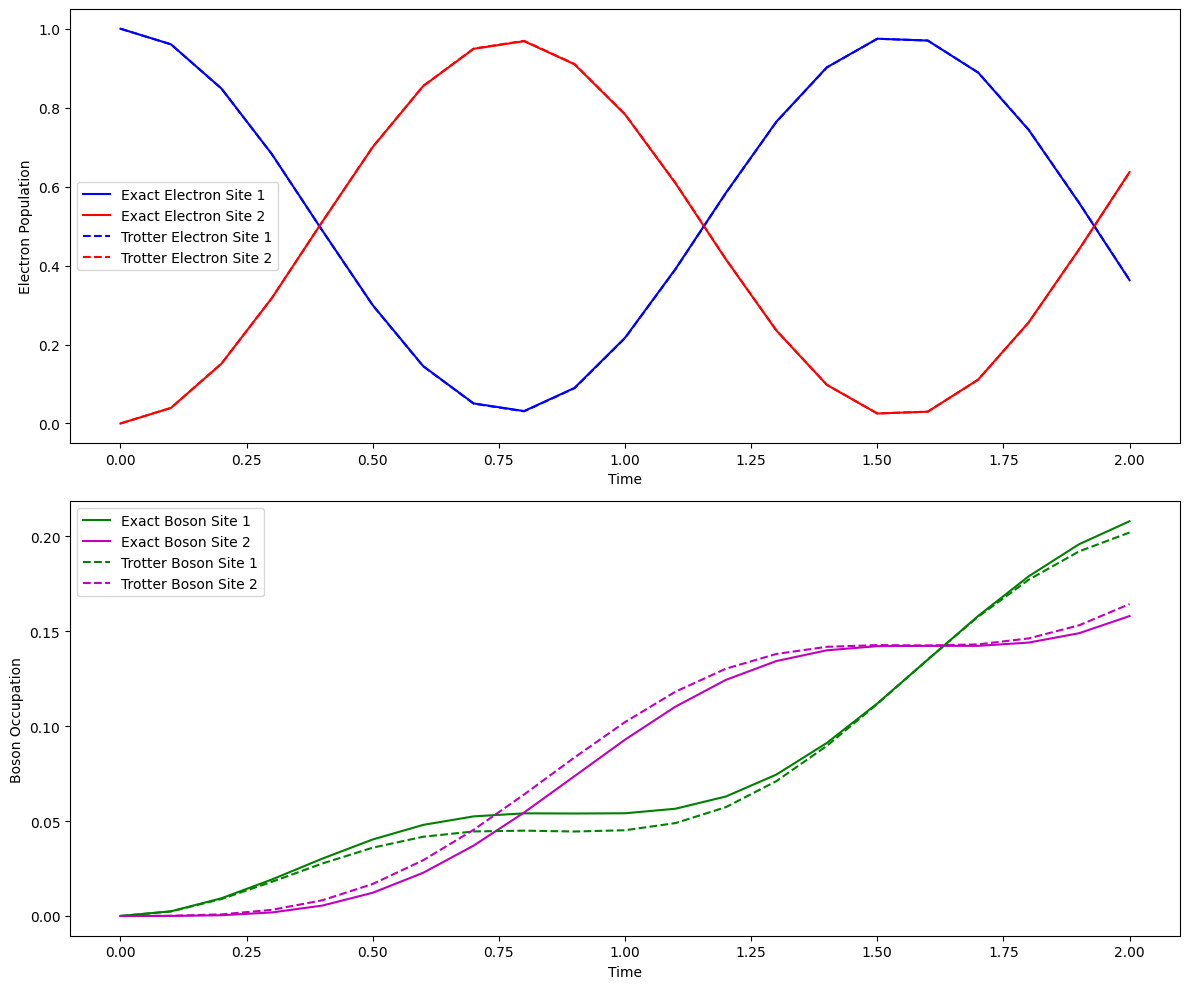

In [ ]:
# Unpack 
times = sim_data["times"]
elec_pop1_exact = sim_data["elec_pop1_exact"]
elec_pop2_exact = sim_data["elec_pop2_exact"]
boson_occ1_exact = sim_data["boson_occ1_exact"]
boson_occ2_exact = sim_data["boson_occ2_exact"]
trotter_elec_pop1 = sim_data["trotter_elec_pop1"]
trotter_elec_pop2 = sim_data["trotter_elec_pop2"]
trotter_boson_occ1 = sim_data["trotter_boson_occ1"]
trotter_boson_occ2 = sim_data["trotter_boson_occ2"]

# Plotting 
plt.figure(figsize=(12, 10))

# Electron populations 
plt.subplot(2, 1, 1)
plt.plot(times, elec_pop1_exact, 'b-', label="Exact Electron Site 1")
plt.plot(times, elec_pop2_exact, 'r-', label="Exact Electron Site 2")
plt.plot(times, trotter_elec_pop1, 'b--', label="Trotter Electron Site 1")
plt.plot(times, trotter_elec_pop2, 'r--', label="Trotter Electron Site 2")
plt.xlabel("Time")
plt.ylabel("Electron Population")
plt.legend()

# Bosonic occupations
plt.subplot(2, 1, 2)
plt.plot(times, boson_occ1_exact, 'g-', label="Exact Boson Site 1")
plt.plot(times, boson_occ2_exact, 'm-', label="Exact Boson Site 2")
plt.plot(times, trotter_boson_occ1, 'g--', label="Trotter Boson Site 1")
plt.plot(times, trotter_boson_occ2, 'm--', label="Trotter Boson Site 2")
plt.xlabel("Time")
plt.ylabel("Boson Occupation")
plt.legend()

plt.tight_layout()
plt.show()

 we're inefficiently sampling statevectors, look into "circuit.save_statevector". put all comments to the side- check if we're correctly slicing modes.